In [1]:
import numpy as np
import pandas as pd
import random
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

%matplotlib inline

In [2]:
from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

In [5]:
data_dir = '/mnt/data/nexar'
ckpt_path = './models/finetuned/faster_rcnn_resnet101_nexar'
labels_path = './nexar_label_map.pbtxt'
num_classes = 5
image_dir = os.path.join(data_dir, 'images')
annotations = pd.read_csv(os.path.join(data_dir, 'train.csv'))

In [6]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(ckpt_path, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [7]:
examples_list = list(annotations['image_filename'])

# use the same split as in training
random.seed(42)
random.shuffle(examples_list)
num_examples = len(examples_list)
num_train = int(0.7 * num_examples)
train_examples = examples_list[:num_train]
val_examples = examples_list[num_train:]

In [8]:
label_map = label_map_util.load_labelmap(labels_path)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [9]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

In [11]:
!nvidia-smi

Mon Sep  4 11:02:23 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 378.13                 Driver Version: 378.13                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Graphics Device     Off  | 0000:01:00.0     Off |                  N/A |
| 29%   51C    P8    20W / 250W |   4447MiB / 11170MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Graphics Device     Off  | 0000:02:00.0     Off |                  N/A |
| 37%   55C    P8    20W / 250W |      0MiB / 11172MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [12]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

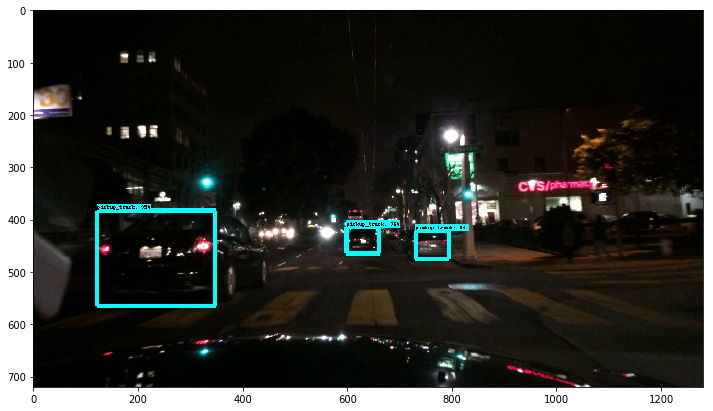

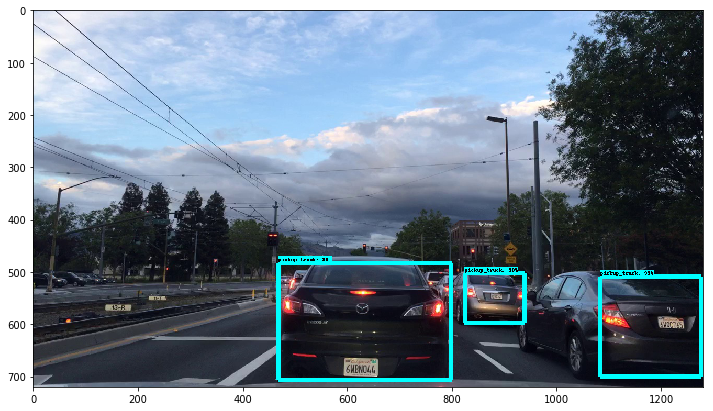

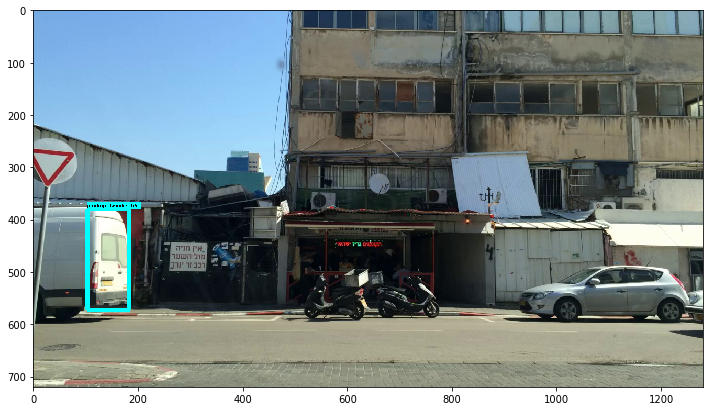

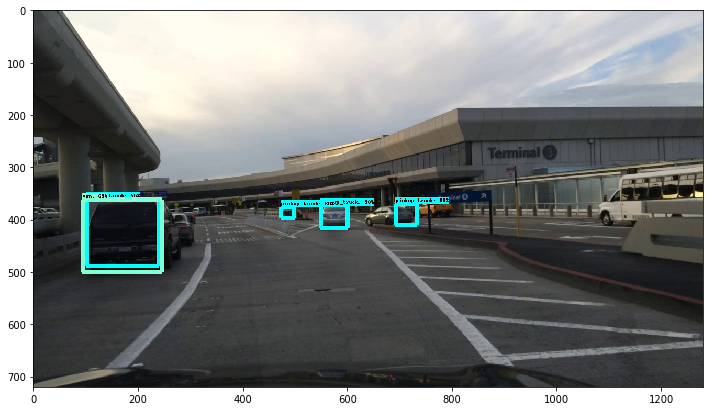

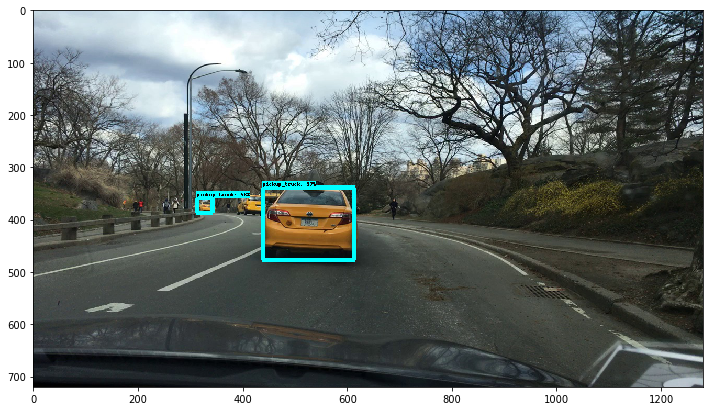

In [13]:
IMAGE_SIZE = (12, 8)

with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        for image_path in val_examples[:5]:
            image = Image.open(os.path.join(image_dir, image_path))
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            # Each box represents a part of the image where a particular object was detected.
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            # Each score represent how level of confidence for each of the objects.
            # Score is shown on the result image, together with the class label.
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            # Actual detection.
            (boxes, scores, classes, num_detections) = sess.run(
                [boxes, scores, classes, num_detections],
                feed_dict={image_tensor: image_np_expanded})
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=8,
                min_score_thresh=.5)
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)